##### Statistics 504 Homework #3 <br>
12/04/2015 <br>
Fall 2015 <br>
Erich Seamon <br>
University of Idaho <br>
erichs@uidaho.edu <br>
http://github.com/erichseamon.com/stat504-python <br>

### DATA1: 

STRONG-R Male Sample_Reduced_2014-03-14.csv (with variables description in  STRONG Codebook.xls). The response variable is FelRecidYr3 (1 versus 0) - Felony recidivism in 3 years.

### DATA2: 

reviews_Musical_Instruments. The response variables is the reviewer’s rating in "overall": 5.0 versus 1.0 (ignore the other in-between ratings of 4.0, 3.0, and 2.0)


#### The common goal for both data sets is to successfully develop a model to predict the response variable given the other explanatory variables/features. <br> 

Conduct a data analysis for the above two Data Sets #1 and #2 using all you have learned in the semester to cleanup, build, and  compare/contrast the performance (10-CV with AUC- measure) of various models (including variables/features selections, 

1) Null,  
2) NB, <br> 
3) knn, <br> 
4) logistic regression, <br> 
5) SVM Polynomial kernel, <br> 
6) SVM Gaussian kernel, <br> 
7) Tree, 7) Bagging, <br> 
8) Random Forest, <br> 
9) Noisy Replications Ensembling, <br> 
10) plus one feasible model of your choice which was not covered in class). <br> <br> 

Overlay all model ROC curves in one figure for the same data set, with a legend key. Discuss your modeling process, interesting findings, and conclusions.

Specifics:

•	Use 10CV mAUC measure to find the optimal model hyper-parameters <br>
•	For SVM, do both the polynomial and Gaussian kernel with the optimal model hyper-meters <br>
•	For Ensembling, do Bagging, Random Forest, and Noisy Replications <br>
•	You probably would have to run these complicated models on Amazon Web Service (AWS) at http://aws.amazon.com/  <br>
•	Measure and report the execution time for running each of these 10 models in Python.   <br>

Make sure that all your Python codes are documented and bug-free-executable, and all your reported results are reproducible. 15% will be deducted from non-executable non-reproducible codes/results.

Finally, please make sure that all your 3 .ipynb Notebooks for Homework#1, #2, and #3 should be in the same Github directory so they can be downloaded in one zip file.


In [382]:
import matplotlib
%matplotlib nbagg

import json
from pprint import pprint
from pyproj import Proj
import StringIO
from pandas import DataFrame
import pandas as pd
import seaborn as sns
import pydot
from IPython.display import Image
import scipy.sparse as sp
import urllib


from urllib2 import Request, urlopen
import json
from pandas.io.json import json_normalize
import numpy
from sklearn.cross_validation import cross_val_score

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pandas as pd

from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt
from sklearn import metrics



### DATA1 - Data Organization - Music

In [430]:
urllib.urlretrieve('http://www.webpages.uidaho.edu/erichs/music.json', '/git/data/hw3/music.json')

('/git/data/hw3/music.json', <httplib.HTTPMessage instance at 0x7ff721080680>)

In [431]:
with open('/git/data/hw3/music.json', 'rU') as f:
    data = [json.loads(row) for row in f]   

In [385]:
data1 = pd.DataFrame(data)
feature_cols = ['asin', 'helpful', 'reviewText', 'reviewTime', 'reviewerID', 'reviewerName', 'summary', 'unixReviewTime']
music_best_worst = data1[(data1.overall==5) | (data1.overall==1)]
music_best_worst_featureadd = music_best_worst[feature_cols] #for use in Task 6

#--Setting X and y for music
musicX = music_best_worst_featureadd
musicy = music_best_worst.overall

In [386]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [387]:
musicX_reviewtext = vect.fit_transform(musicX.reviewText)

In [388]:
musicX_reviewtext= sp.issparse(musicX_reviewtext)

In [389]:
musicX_reviewtext

True

### DATA2 Data Organization - Recidivism

In [432]:
urllib.urlretrieve('http://webpages.uidaho.edu/~stevel/504/STRONG-R Male Sample_Reduced_2014-03-14.csv', '/git/data/hw3/strong.csv')

('/git/data/hw3/strong.csv', <httplib.HTTPMessage instance at 0x7ff725c03ab8>)

In [433]:
data2 = pd.read_csv('/git/data/hw3/strong.csv')
data2['FelRecidYr3'].replace('', np.nan, inplace=True)

In [392]:
filter = data2["FelRecidYr3"] != " "
data2 = data2[filter]

In [393]:
feature_cols2 = ['AgeAsses3RN', 'AgeAtFirstConvR', 'JvFelCon', 'JvVioCon', 'JvComit', 'HomConv', 'SexConv', 'VProCon', 'AssaCon', 'DomVio', 'CopFodNd3', 'CopBugNd3', 'CopTraNd3', 'CopHygNd3', 'CopMedNd3', 'CopMHNd3']
X = data2[feature_cols2]
y = data2.FelRecidYr3.astype(int)

#y = pd.DataFrame(strongy)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)
y

0        0
1        1
3        0
4        1
7        0
8        0
9        0
10       0
11       0
12       0
14       0
15       0
16       1
17       1
19       0
22       0
23       0
24       0
25       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
37       0
39       0
40       0
        ..
39095    0
39098    0
39100    1
39102    1
39104    0
39107    0
39109    0
39110    0
39111    1
39113    0
39114    0
39115    0
39122    0
39123    0
39124    1
39125    1
39126    1
39127    0
39128    0
39130    1
39133    0
39135    1
39138    1
39139    0
39143    0
39146    0
39147    1
39150    0
39152    0
39153    1
Name: FelRecidYr3, dtype: int64

## 10-fold cross-validation with all three features

In [422]:
lm = LinearRegression()
scores = cross_val_score(lm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='mean_squared_error')
print scores

[-0.20346957 -0.20018375 -0.2012021  -0.19961081 -0.19804856 -0.19347437
 -0.19305239 -0.20056708 -0.19595228 -0.19547802]


In [423]:
# fix the sign of MSE scores
mse_scores = -scores
print mse_scores

[ 0.20346957  0.20018375  0.2012021   0.19961081  0.19804856  0.19347437
  0.19305239  0.20056708  0.19595228  0.19547802]


In [424]:
# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)
print rmse_scores

[ 0.45107601  0.44741899  0.44855557  0.44677826  0.44502647  0.43985721
  0.43937728  0.44784717  0.44266497  0.44212897]


In [425]:
# calculate the average RMSE
print rmse_scores.mean()

0.445073088756


## Null Accuracy

In [394]:
# calculate the null accuracy
y_test.value_counts().head(1) / len(y_test)

0    0.698353
dtype: float64

## KNN

In [399]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=9)
strongy = data2.FelRecidYr3
scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print scores

[ 0.67118803  0.66230122  0.69831618  0.6939635   0.69723912  0.67430978
  0.68554048  0.67197005  0.68975199  0.68460459]


In [400]:
# use average accuracy as an estimate of out-of-sample accuracy
print scores.mean()

0.682918492961


In [218]:
# search for an optimal value of K for KNN
k_range = range(1, 100)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    k_scores.append(scores.mean())
print k_scores

KeyboardInterrupt: 

In [ ]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## Logistic Regression

In [416]:
# 10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X,y)
print cross_val_score(logreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
print cross_val_score(logreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()

0.701212959951
0.658488969462


<IPython.core.display.Javascript object>


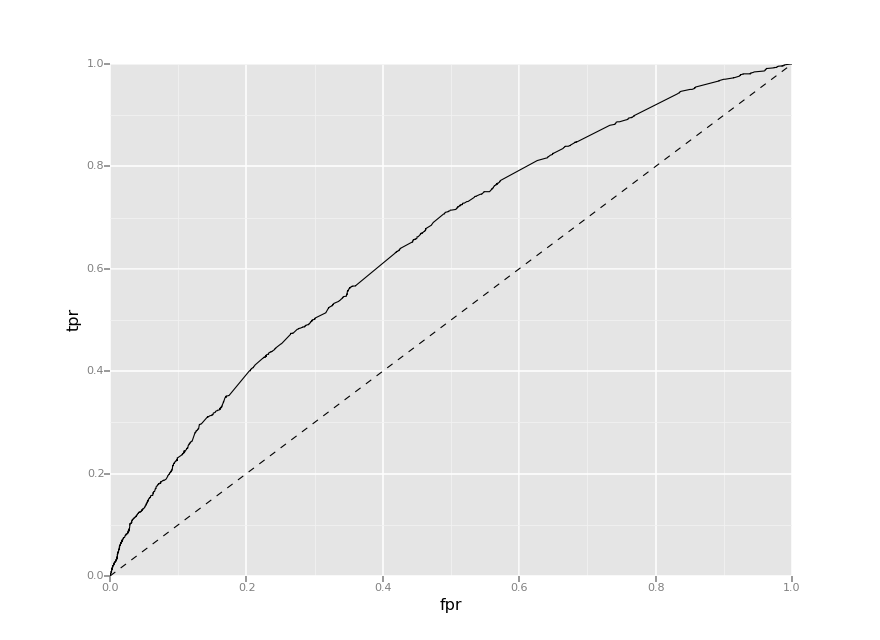

<ggplot: (8793716986381)>

In [421]:
from sklearn import metrics
import pandas as pd
from ggplot import *

preds = logreg.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))

# TASK 7: plot the ROC curve
import matplotlib
%matplotlib nbagg

import matplotlib.pyplot as plt
roc_knn2 = metrics.roc_curve(knn_y_test_binary, knn_y_pred_prob)
knn_fpr2, knn_tpr2, thresholds2 = roc_knn2
plt.plot(knn_fpr2, knn_tpr2, color='blue')

roc_log2 = metrics.roc_curve(log_y_test_binary, log_y_pred_prob)
log_fpr2, log_tpr2, thresholds2 = roc_log2
plt.plot(log_fpr2, log_tpr2, color='magenta')

roc_tree2 = metrics.roc_curve(tree_y_test_binary, tree_y_pred_prob)
tree_fpr2, tree_tpr2, thresholds2 = roc_tree2
plt.plot(tree_fpr2, tree_tpr2, color='green')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')





ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

In [228]:
log_y_test_binary = np.where(y_test==1, 0, 2)

In [417]:
fpr

array([  0.00000000e+00,   2.67952840e-04,   2.67952840e-04, ...,
         9.98660236e-01,   9.99732047e-01,   1.00000000e+00])

In [418]:
tpr

array([  0.00000000e+00,   0.00000000e+00,   6.20347395e-04, ...,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00])